In [55]:
%matplotlib inline
import matplotlib.pyplot as plt

In [56]:
import numpy as np
import kwant

In [3]:
def make_1d_junction(a=10, d=50, add_left_lead=True, add_right_lead=True):
    lat = kwant.lattice.chain(a)
    syst = kwant.Builder()
    
    def shape_junction(pos):
        x = pos[0]
        return -d <= x <= d
    def onsite(site, t_L, t_R, t_tunnel, mu_L, mu_R):
        x = site.pos[0]
        if x < -5:
            return 2 * t_L - mu_L
        elif x > 15:
            return 2 * t_R - mu_R
        elif x == 0:
            return 1 * t_L + 1 * t_tunnel - mu_L
        elif x == 10:
            return 1 * t_R + 1 * t_tunnel - mu_R
        
    def hopping(site1, site2, t_L, t_R, t_tunnel):
        x1 = site1.pos[0]
        x2 = site2.pos[0]
        if x1 > 5 and x2 > 5:
            return -t_R
        elif x1 < 5 and x2 < 5:
            return -t_L
        else:
            return -t_tunnel
        
    def onsite_left_lead(site, t_L, mu_L):
        return 2 * t_L - mu_L
    def hopping_left_lead(site1, site2, t_L):
        return -t_L
    
    def onsite_right_lead(site, t_R, mu_R):
        return 2 * t_R - mu_R
    def hopping_right_lead(site1, site2, t_R):
        return -t_R
        
    
    syst[lat.shape(shape_junction, [0])] = onsite
    syst[lat.neighbors()] = hopping
    
    if add_left_lead is True:
        sym_left_lead = kwant.TranslationalSymmetry([-a])
        left_lead = kwant.Builder(sym_left_lead)
        left_lead[lat(0)] = onsite_left_lead
        left_lead[lat.neighbors()] = hopping_left_lead
        syst.attach_lead(left_lead)
    
    if add_right_lead is True:
        sym_right_lead = kwant.TranslationalSymmetry([a])
        right_lead = kwant.Builder(sym_right_lead)
        right_lead[lat(2)] = onsite_right_lead
        right_lead[lat.neighbors()] = hopping_right_lead
        syst.attach_lead(right_lead)
    return syst.finalized()

In [41]:
def get_T(syst, params):
    smatrix = kwant.smatrix(syst, energy=0.001, params=params)
    T = smatrix.transmission(1, 0) ### from lead-0 to lead-1
    return T

# Analytic

In [30]:
m = 1
M = 2
mu_L = 30
v_L = np.sqrt(mu_L / m)
mu_R_range = np.linspace(1, 100, 100)
v_R = np.sqrt(mu_R_range / M)
T_sq_analytic = 4 * v_L * v_R / (v_L + v_R)**2

In [44]:
mu_R_range = np.linspace(0.01, 5, 100)

# Numeric

In [51]:
junction_geo_params = dict(
    a=10,
    d=50,
    add_left_lead=True,
    add_right_lead=True
)
junction = make_1d_junction(**junction_geo_params)

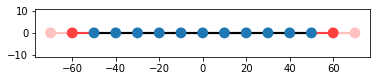

In [52]:
kwant.plot(junction)
plt.show()

In [57]:
junction_geo_params = dict(
    a=10,
    d=50,
    add_left_lead=True,
    add_right_lead=True
)
junction = make_1d_junction(**junction_geo_params)

In [58]:
junction_ham_params = dict(
    t_L=100/m,
    t_R=100/M,
    t_tunnel=100/np.sqrt(m*M),
    #t_tunnel=200/(m + M),
    mu_L=30,
    mu_R=0
)

In [59]:
T_vs_mu_R = []
Tana_vs_mu = []
for mu in mu_R_range:
    junction_ham_params['mu_L'] = mu
    junction_ham_params['mu_R'] = mu
    T = get_T(syst=junction, params=junction_ham_params)
    T_vs_mu_R.append(T)
    
    v_L = np.sqrt(mu / m)
    v_R = np.sqrt(mu / M)
    T_sq_analytic = 4 * v_L * v_R / (v_L + v_R)**2
    Tana_vs_mu.append(T_sq_analytic)
T_vs_mu_R = np.asarray(T_vs_mu_R)

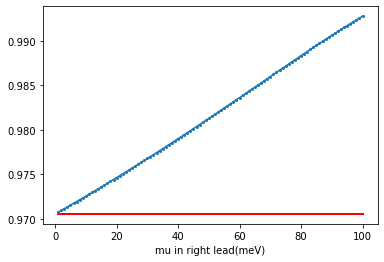

In [60]:
plt.figure()
plt.plot(mu_R_range, Tana_vs_mu, 'r', linewidth=2)
# plt.plot(mu_R_range, np.ones(len(mu_R_range)), 'k--')
plt.plot(mu_R_range, T_vs_mu_R, marker='o', markersize=2)
# plt.plot(mu_R_range, np.asarray(Tana_vs_mu) - T_vs_mu_R, '.-')
plt.xlabel('mu in right lead(meV)')
# plt.xlim([0, 5])
# plt.ylabel('T')
# plt.ylim([0.9, 1.1])
plt.show()

In [259]:
n = np.argmax(np.asarray(T_vs_mu_R))
print(n)

2


In [42]:
T_vs_mu_R[12]

0.9954558210946814

In [44]:
mu_R_range[n-1]

3.0303030303030303

In [24]:
np.sqrt(13/1)

3.605551275463989

In [25]:
np.sqrt(4.02/0.3)

3.660601043544625

# scan t_tunnel

## A. analytics

In [19]:
m = 1
M = 0.5
mu_L = 30
v_L = np.sqrt(mu_L / m)
mu_R = 30
v_R = np.sqrt(mu_R / M)
T_sq_analytic = 4 * v_L * v_R / (v_L + v_R)**2

In [20]:
print(T_sq_analytic)

0.9705627484771407


In [21]:
1 - 0.9705627484771407

0.029437251522859254

## B. numerics

In [22]:
junction_ham_params = dict(
    t_L=100/m,
    t_R=100/M,
    t_tunnel=100/1,
    mu_L=30,
    mu_R=15
)

In [75]:
100 / np.sqrt(m * M)

316.2277660168379

In [76]:
200 / (m + M)

181.8181818181818

In [23]:
t_tunnel_range = np.linspace(0, 1000, 200)

In [24]:
T_vs_t_tunnel = []
for junction_ham_params['t_tunnel'] in t_tunnel_range:
    T = get_T(syst=junction, params=junction_ham_params)
    T_vs_t_tunnel.append(T)
T_vs_t_tunnel = np.asarray(T_vs_t_tunnel)

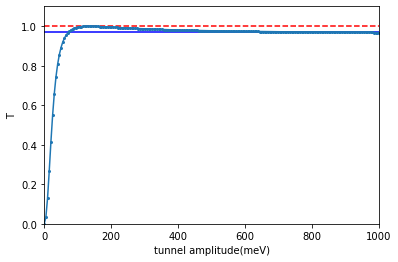

In [25]:
plt.figure()
plt.plot(t_tunnel_range, T_sq_analytic*np.ones(len(t_tunnel_range)), 'b')
plt.plot(t_tunnel_range, np.ones(len(t_tunnel_range)), 'r--')
plt.plot(t_tunnel_range, T_vs_t_tunnel, marker='o', markersize=2)
plt.xlabel('tunnel amplitude(meV)')
plt.xlim([0, 1000])
plt.ylabel('T')
plt.ylim([0, 1.1])
plt.show()

In [80]:
n = np.argmin(abs(T_vs_t_tunnel - T_sq_analytic))
t_tunnel_range[n]

316.58291457286435

In [270]:
40**2 * np.sqrt(3) / 4 * 6 * 1000 / 2**3

519615.2422706632

# different m, different a

In [262]:
def make_1d_junction_diffa(a=10, d=50, add_left_lead=True, add_right_lead=True):
    lat = kwant.lattice.chain(a)
    syst = kwant.Builder()
    
    def shape_junction(pos):
        x = pos[0]
        return -d <= x <= d
    def onsite(site, t1, t2, t_L, t_R, mu_L, mu_R):
        x = site.pos[0]
        if x < -15:
            return 2 * t_L - mu_L
        elif x > 15:
            return 2 * t_R - mu_R
        elif x == -10:
            return t_L + t1 - mu_L
        elif x == 0:
            return t1 + t2 - mu_L
        elif x == 10:
            return t2 + t_R - mu_R
        
    def hopping(site1, site2, t1, t2, t_L, t_R):
        x1 = site1.pos[0]
        x2 = site2.pos[0]
        if x1 > 5 and x2 > 5:
            return -t_R
        elif x1 < -5 and x2 < -5:
            return -t_L
        elif (x1 == 0 and x2 == -10) or (x1 == -10 and x2 == 0):
            return -t1
        elif (x1 == 10 and x2 == 0) or (x1 == 0 and x2 == 10):
            return -t2
        
    def onsite_left_lead(site, t_L, mu_L):
        return 2 * t_L - mu_L
    def hopping_left_lead(site1, site2, t_L):
        return -t_L
    
    def onsite_right_lead(site, t_R, mu_R):
        return 2 * t_R - mu_R
    def hopping_right_lead(site1, site2, t_R):
        return -t_R
        
    
    syst[lat.shape(shape_junction, [0])] = onsite
    syst[lat.neighbors()] = hopping
    
    
    if add_left_lead is True:
        sym_left_lead = kwant.TranslationalSymmetry([-a])
        left_lead = kwant.Builder(sym_left_lead)
        left_lead[lat(-3)] = onsite_left_lead
        left_lead[lat.neighbors()] = hopping_left_lead
        syst.attach_lead(left_lead)
    
    if add_right_lead is True:
        sym_right_lead = kwant.TranslationalSymmetry([a])
        right_lead = kwant.Builder(sym_right_lead)
        right_lead[lat(3)] = onsite_right_lead
        right_lead[lat.neighbors()] = hopping_right_lead
        syst.attach_lead(right_lead)
    return syst.finalized()

In [263]:
junction_geo_params = dict(
    a=10,
    d=50,
    add_left_lead=True,
    add_right_lead=True
)
junction_a = make_1d_junction_diffa(**junction_geo_params)

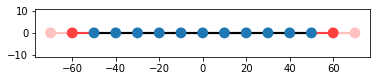

In [264]:
kwant.plot(junction_a)
plt.show()

In [265]:
a_L = 1
a_R = 0.3
a_avg = (a_L * a_R) / 2
m_avg = np.sqrt(m*M)
junction_a_ham_params = dict(
    t_L=100 / (m * a_L**2),
    t_R=100 / (M * a_R**2),
    t1=100 / (m * a_avg * a_L),
    t2=100/ (m_avg * a_avg * a_R),
    mu_L=30,
    mu_R=0
)

In [266]:
T_vs_mu_R = []
for junction_a_ham_params['mu_R'] in mu_R_range:
    T = get_T(syst=junction_a, params=junction_a_ham_params)
    T_vs_mu_R.append(T)
T_vs_mu_R = np.asarray(T_vs_mu_R)

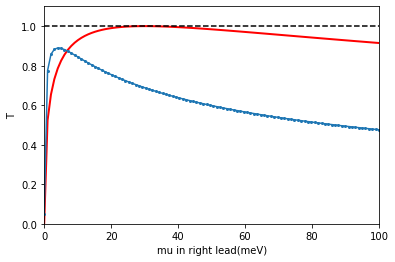

In [267]:
plt.figure()
plt.plot(mu_R_range, T_sq_analytic, 'r', linewidth=2)
plt.plot(mu_R_range, np.ones(len(mu_R_range)), 'k--')
plt.plot(mu_R_range, T_vs_mu_R, marker='o', markersize=2)
plt.xlabel('mu in right lead(meV)')
plt.xlim([0, max(mu_R_range)])
plt.ylabel('T')
plt.ylim([0, 1.1])
plt.show()